# Title

## 1 The Business Analytical Question

In this notebook, the AirBnb summary data for New York is explored, transformed and analysed in order to answer the question, "what factors influence whether or not a listing is reviewed?". **This question was chosen because....**

### Frame the problem

How will Airbnb benefit from the model?

If we can ascertain the features that contribute to the "success" of a listing (represented by whether or not it receives reviews), we can direct marketing energy towards potential hosts who are more likely to succeed.

### Previous attempts at the problem



## 2.1 Exploratory Data Analysis (EDA)

First, the required libraries and data are imported.

In [1]:
# import libraries

import math

from typing import List, Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, f1_score, classification_report, plot_confusion_matrix, make_scorer

from xgboost import XGBClassifier, plot_importance
import xgboost as xgb

In [2]:
airbnb = pd.read_csv('data/AB_NYC_2019.csv')

airbnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
num_listings = len(airbnb)
num_hosts = len(airbnb['host_id'].unique())

print(f'The data contains information about {num_listings} AirBnB listings from {num_hosts} hosts')

The data contains information about 48895 AirBnB listings from 37457 hosts


### 2.1.1 Missing values

In [4]:
# check for missing values

airbnb.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Some of these columns are irrelevant to the number of reviews being posted. For example, there's no mechanism by which id, host_name, and host_id could impact the number of reviews. The IDs are identifiers used to track the listings in other data sets (for example, AirBnb likely has data sets of reviews and host details). 

There may be information within the 'name' column that could influence the presence of reviews - for example, the name may list amenities such as a hot tub or garden that would make the listing more likely to be booked and then reviewed. However, this is beyond the scope of this project, so the name column will be removed from the dataset.

Therefore we can safely drop the columns `id`, `name`, `host_id`, and `host_name`, which will in turn address the missing values in `name` and `host_name`.

In [5]:
airbnb = airbnb.drop(columns= ['id', 'name', 'host_id', 'host_name'])
airbnb.isna().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Let's investigate these missing values for `last review` and `reviews_per_month`

In [6]:
airbnb[airbnb['last_review'].isna()]['number_of_reviews'].value_counts()

0    10052
Name: number_of_reviews, dtype: int64

In [7]:
airbnb[airbnb['reviews_per_month'].isna()]['number_of_reviews'].value_counts()

0    10052
Name: number_of_reviews, dtype: int64

In [8]:
len(airbnb[airbnb['number_of_reviews']==0])

10052

The missing values correspond to rows where there are no reviews. In these cases there is no date of last review because there have been no reviews, and `reviews_per_month` cannot be calculated.

Therefore we can fill the missing values with 0. It won't make a difference, however, as `reviews_per_month` and `last_review` are so strongly correlated with `number of reviews` that we will not be using them as features in the model.

In [9]:
airbnb.fillna(0, inplace = True)
airbnb.isna().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [10]:
airbnb.drop(columns = ['last_review', 'reviews_per_month'], inplace = True)
airbnb.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0


### 2.1.2 Split training and test data

At this point we should separate our training data from our test data. We will note all of the steps we perform on the training data and repeat them on the test data. This prevents information leakage from the test set **(CITE)**.


In [11]:
# withholding a very small slice for final evaluation of selected & tuned model
airbnb, final_test_set = train_test_split(airbnb, random_state = 42, test_size = 0.1) 

# Take test set for model selection and tuning
raw_train, raw_test = train_test_split(airbnb, random_state = 42, test_size = 0.2)
raw_train.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
19973,Brooklyn,Bedford-Stuyvesant,40.68724,-73.95068,Private room,41,7,9,1,0
4993,Manhattan,West Village,40.73002,-74.00653,Entire home/apt,200,7,16,1,50
46695,Manhattan,Chelsea,40.74114,-74.00358,Entire home/apt,198,30,0,1,125
24911,Manhattan,Harlem,40.82329,-73.95184,Private room,110,3,0,3,64
14367,Manhattan,West Village,40.73386,-74.00460,Entire home/apt,199,1,10,1,0


### 2.1.3 Encode the Target Variable

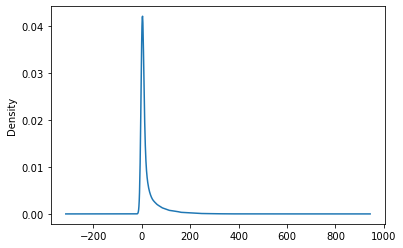

In [12]:
airbnb['number_of_reviews'].plot(kind = 'density');

Because we are looking to target listings that have received no reviews, it makes more sense to covert the number of reviews into binary classes (1 for 'has reviews' and 0 for 'does not have reviews')

In [13]:
# Encode target variable as 0 (no reviews) or 1 (reviews)

def encode_target(df: pd.DataFrame) -> pd.DataFrame:
    feature_col = 'number_of_reviews'
    new_df = df.copy()
    new_df['has_reviews'] = df[feature_col].apply(lambda r: 0 if r == 0 else 1)
    return new_df.drop(columns = [feature_col])

raw_train = encode_target(raw_train)
raw_test = encode_target(raw_test)

In [14]:
"""
Make a copy of the training data to explore during EDA. 
We can try transformations on this dataset to see if they improve the distributions. 
If they work, apply them to the training and test sets.
"""
eda_data = raw_train.copy()

### 2.1.4 EDA

Next, examine the distribution of numeric features.

In [15]:
### Numerical attributes

numerical_data = eda_data.select_dtypes('number')
#sns.pairplot(numerical_data);

**comment on this**

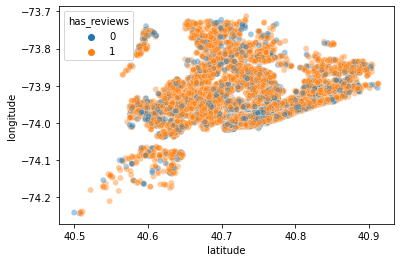

In [16]:
sns.scatterplot(data = eda_data, x = 'latitude', y = 'longitude', hue = 'has_reviews', alpha = 0.4);

In [17]:
def plot_distribution(df, col_of_interest, title = None, color_split = 'has_reviews'):
    if title == None:
        title = "Distribution of "+ col_of_interest.replace('_', ' ') + " of AirBnB listings in New York City"
    fig, ax = plt.subplots(figsize = (10,8))
    ax.set_title(title)
    df[df[color_split]==1][col_of_interest].plot(kind = 'density', ax = ax, label = 'has reviews')
    df[df[color_split]==0][col_of_interest].plot(kind = 'density', ax = ax, label = 'does not have reviews')
    ax.plot(df[col_of_interest], [-0.0001]*len(df[col_of_interest]), '|', color='k')
    ax.legend();
    return ax

<AxesSubplot:title={'center':'Distribution of latitude of AirBnB listings in New York City'}, ylabel='Density'>

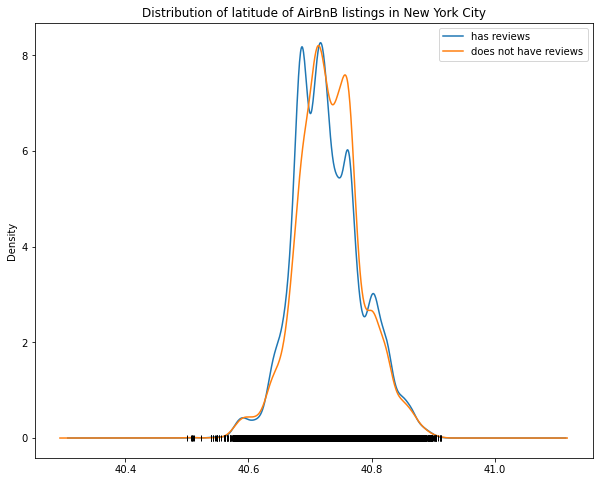

In [18]:
plot_distribution(eda_data, 'latitude')

<AxesSubplot:title={'center':'Distribution of longitude of AirBnB listings in New York City'}, ylabel='Density'>

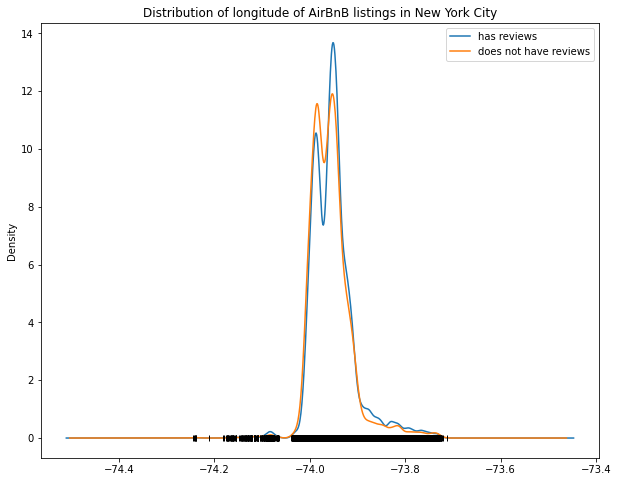

In [19]:
plot_distribution(eda_data, 'longitude')

<AxesSubplot:title={'center':'Distribution of price of AirBnB listings in New York City'}, ylabel='Density'>

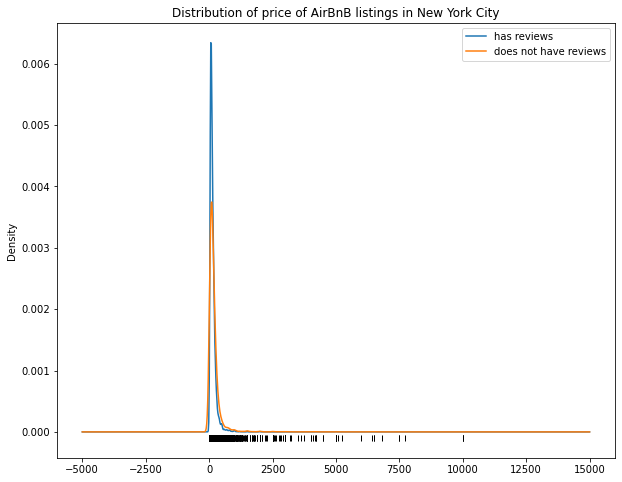

In [20]:
plot_distribution(eda_data, 'price')

The price distribution looks like it might be log normal. Transform it to get a normally distributed variable.

<AxesSubplot:title={'center':'Distribution of log price of AirBnB listings in New York City'}, ylabel='Density'>

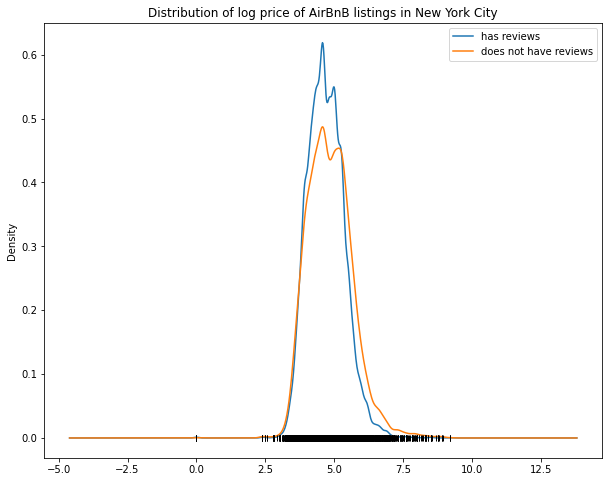

In [21]:
eda_data['log_price'] = eda_data['price'].apply(lambda p: np.log(p+1))
plot_distribution(eda_data, 'log_price')

The natural logarithm of price is approximately normally distributed.

<AxesSubplot:title={'center':'Distribution of availability of AirBnB listings (days out of 365)'}, ylabel='Density'>

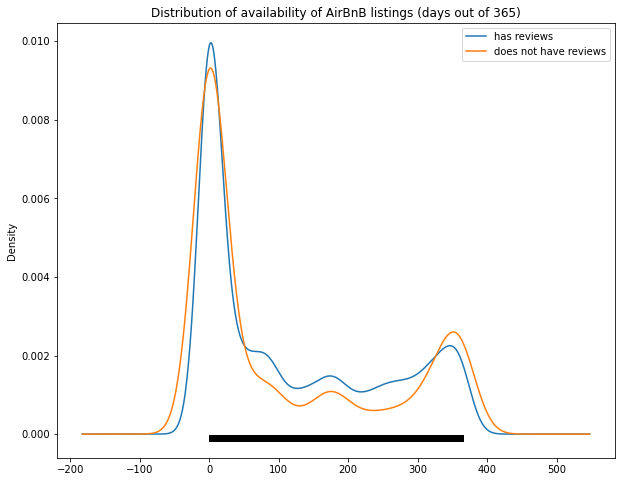

In [22]:
plot_distribution(eda_data, 'availability_365', title = 'Distribution of availability of AirBnB listings (days out of 365)')

It seems that a high proportion of listings are not actually available (availability = 0). These listings will be examined more closely. If they are not available now, have they ever been available? If any of them have reviews, it would imply that they have been available in the past.

In [23]:
eda_data[eda_data['availability_365']==0][['availability_365', 'has_reviews']].groupby(['has_reviews']).count()

,availability_365
has_reviews,
0,3491
1,9084


Many of the listings that are unavailable still have reviews. This suggests that at the time of the review(s), their availability was greater than 0. Going forward, we should bear in mind that the availability of the listings changes over time and we only have access to the value of availability at a single point in time. This might make the `availability_365` feature unreliable.

Make the data continuous by converting to the fraction of the year when the listing is available.

<AxesSubplot:title={'center':'Distribution of availability frac of AirBnB listings in New York City'}, ylabel='Density'>

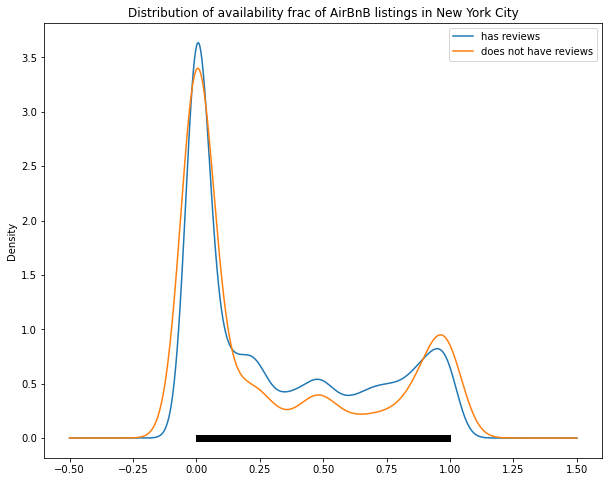

In [24]:
eda_data['availability_frac'] = eda_data['availability_365'] / 365
plot_distribution(eda_data, 'availability_frac')

<AxesSubplot:title={'center':'Distribution of calculated host listings count of AirBnB listings in New York City'}, ylabel='Density'>

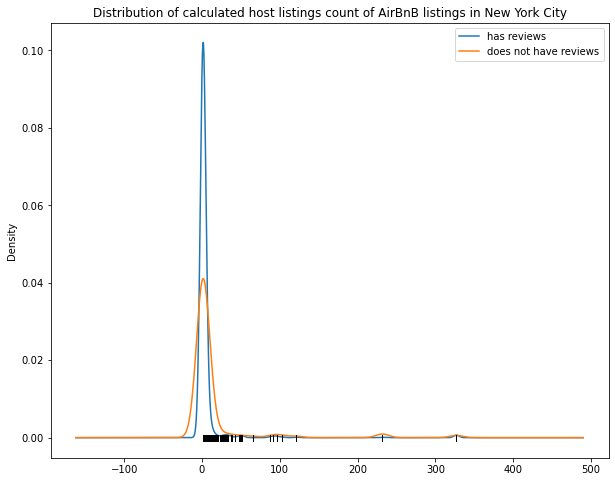

In [25]:
plot_distribution(eda_data, 'calculated_host_listings_count')

Again, this looks like a log normal distribution with some very large outliers.

<AxesSubplot:title={'center':'Distribution of log calculated host listings count of AirBnB listings in New York City'}, ylabel='Density'>

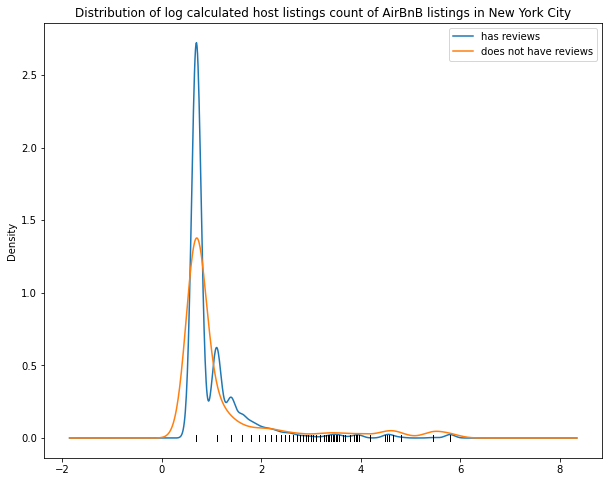

In [26]:
# since we are now performing log twice we should create a function that we will apply to the test and training data.
def transform_log_normal_variables(df: pd.DataFrame, columns_to_transform: List[str], drop = True) -> pd.DataFrame:
    new_df = df.copy()
    for col in columns_to_transform:
        new_column = 'log_' + col
        new_df[new_column] = new_df[col].apply(lambda x: np.log(x+1)) # prevent ln 0 errors
    if drop:
        new_df.drop(columns = columns_to_transform, inplace = True)
    return new_df

eda_data = transform_log_normal_variables(eda_data, ['calculated_host_listings_count'], drop = False)
plot_distribution(eda_data, 'log_calculated_host_listings_count')

On inspection it does not appear to be a log normal distribution. The data is bounded by 0 and has a long tail in the positive direction.

In [27]:
eda_data.drop(columns= ['log_calculated_host_listings_count'], inplace = True)

<AxesSubplot:title={'center':'Distribution of minimum nights of AirBnB listings in New York City'}, ylabel='Density'>

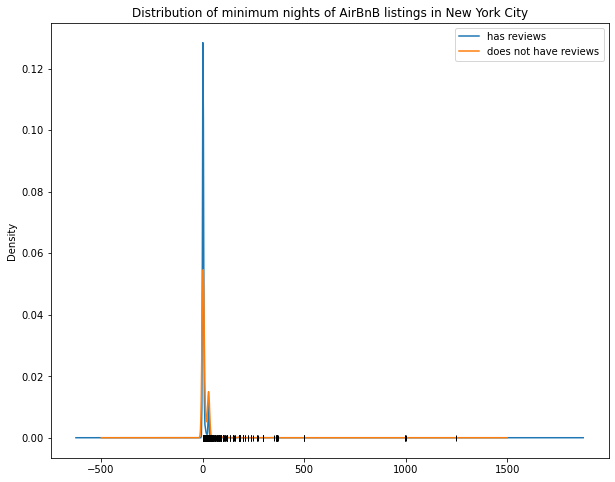

In [28]:
plot_distribution(eda_data, 'minimum_nights')

This variable also has some extreme outliers.

Minimum nights greater than a few month lean more towards tenancy than holiday stay.

<AxesSubplot:title={'center':'Distribution of availability 365 of AirBnB listings in New York City'}, ylabel='Density'>

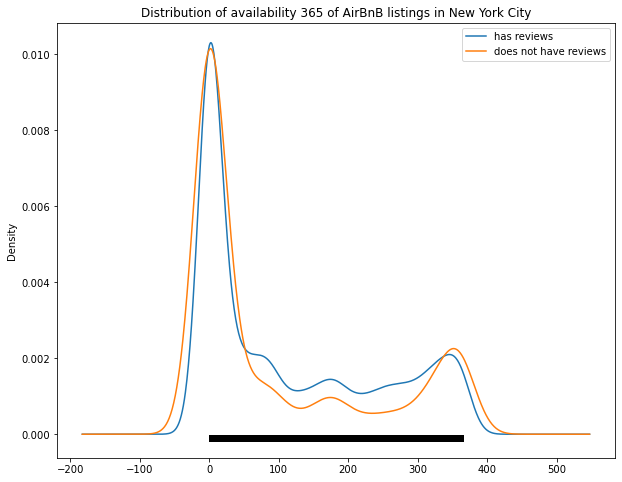

In [29]:
class OutlierRemover:
    def __init__(self, min_z_score = -3, max_z_score = 3):
        self.min_z_score = min_z_score
        self.max_z_score = max_z_score
        self.means_sds = {}
        self.list_of_columns = []
    def fit(self, data, list_of_columns = []):
        if len(list_of_columns)==0:
            list_of_columns = data.columns
        self.list_of_columns = list_of_columns
        for col in list_of_columns:
            mean = data[col].mean()
            sd = np.sqrt(data[col].var())
            self.means_sds[col] = (mean, sd)
    def calculate_z_score(self, value, col):
        return (value - self.means_sds[col][0])/self.means_sds[col][1]
    def transform(self, data):
        if len(self.means_sds.keys())==0:
            print("Transformer must be fit before transformation. Call .fit(data) or .fit_transform(data)")
            return
        for col in self.list_of_columns:
            z_scores = data[col].apply(self.calculate_z_score, col=col)
            keep = (z_scores>self.min_z_score)&(z_scores<self.max_z_score)
            data = data[keep]
        return data
    def fit_transform(self, data, list_of_cols = []):
        self.fit(data, list_of_cols)
        return self.transform(data)
    
o_r = OutlierRemover()

numerical_features = eda_data.select_dtypes('number')
eda_data[numerical_features.columns] = o_r.fit_transform(numerical_features)
plot_distribution(eda_data, 'availability_365')

<AxesSubplot:title={'center':'Distribution of minimum nights of AirBnB listings in New York City'}, ylabel='Density'>

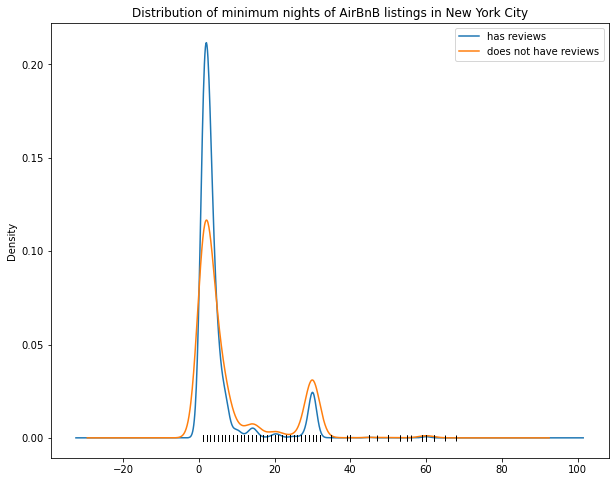

In [30]:
plot_distribution(eda_data, 'minimum_nights')

### Categorical features

In [31]:
eda_data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,has_reviews,log_price,availability_frac
19973,Brooklyn,Bedford-Stuyvesant,40.68724,-73.95068,Private room,41.0,7.0,1.0,0.0,1.0,3.737670,0.000000
4993,Manhattan,West Village,40.73002,-74.00653,Entire home/apt,200.0,7.0,1.0,50.0,1.0,5.303305,0.136986
46695,Manhattan,Chelsea,40.74114,-74.00358,Entire home/apt,198.0,30.0,1.0,125.0,0.0,5.293305,0.342466
24911,Manhattan,Harlem,40.82329,-73.95184,Private room,110.0,3.0,3.0,64.0,0.0,4.709530,0.175342
14367,Manhattan,West Village,40.73386,-74.00460,Entire home/apt,199.0,1.0,1.0,0.0,1.0,5.298317,0.000000


<AxesSubplot:xlabel='room_type', ylabel='log_price'>

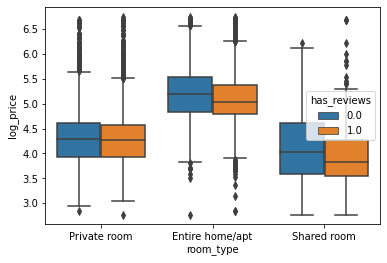

In [32]:
sns.boxplot(data = eda_data, x = 'room_type', y = 'log_price', hue = 'has_reviews')

In [33]:
eda_data['neighbourhood_group'].unique()

array(['Brooklyn', 'Manhattan', 'Queens', 'Bronx', 'Staten Island'],
      dtype=object)

<AxesSubplot:xlabel='neighbourhood_group', ylabel='log_price'>

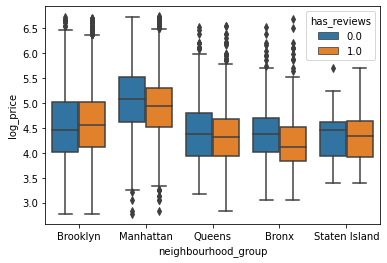

In [34]:
sns.boxplot(data = eda_data, x = 'neighbourhood_group', y = 'log_price', hue = 'has_reviews')

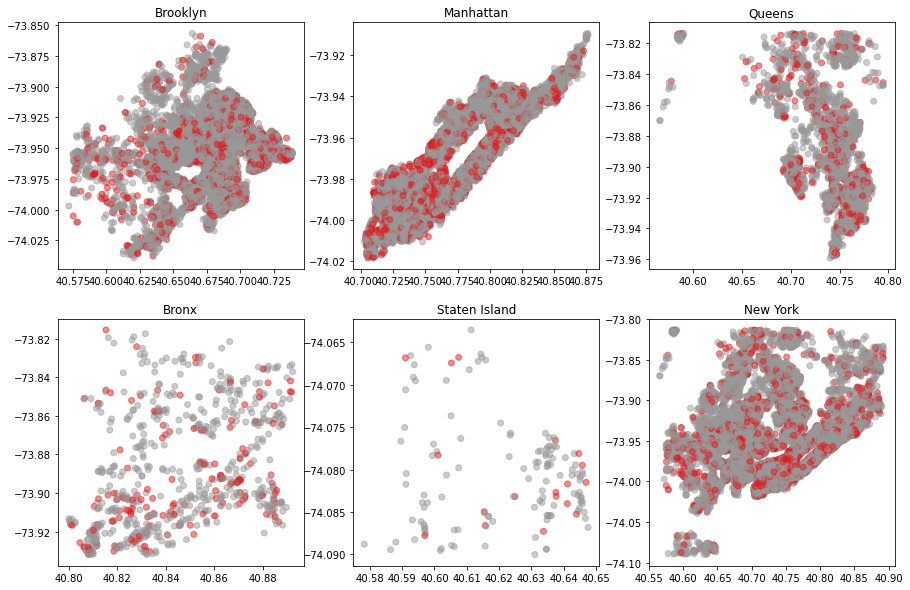

In [35]:
fig, axs = plt.subplots(ncols = 3, nrows =2, figsize = (15,10))

neighs = eda_data['neighbourhood_group'].unique().tolist() + ['New York']
i = 0

for row in range(2):
    for col in range(3):
        if i < 5:
            neigh_dat = eda_data[eda_data['neighbourhood_group']==neighs[i]]
        else:
            neigh_dat = eda_data
        axs[row, col].scatter(x = neigh_dat['latitude'], y = neigh_dat['longitude'], 
                              c = neigh_dat['has_reviews'], alpha = 0.5, cmap = 'Set1')
        axs[row, col].set_title(neighs[i])
        i+=1

Even though one could argue that entire home is "better" than private room, assigning the room types values 1, 2, and 3 would assume that they are equally spaced. These  values will be one hot encoded instead.
For now, neighbourhood and neighbourhood group will **not** be used - the assumption is that the information about vicinity is adequately encoded by latitude and longitude. They can be brought back in later if needed.



In [36]:
ohe = OneHotEncoder()

def adjust_column_headers(col: str):
    return col.lower().replace(' ', '_')

def one_hot_encode(df, col_to_encode, ohe: OneHotEncoder, fit = True, col_to_drop = None) -> pd.DataFrame:
    data_to_encode = df[[col_to_encode]]
    if fit:
        ohe_data_array = ohe.fit_transform(data_to_encode).toarray()
    else:
        ohe_data_array = ohe.transform(data_to_encode).toarray()
    column_names = ohe.get_feature_names([col_to_encode])
    column_names = [adjust_column_headers(col) for col in column_names]
    col_to_drop = col_to_encode + '_' + adjust_column_headers(col_to_drop)
    ohe_data = pd.DataFrame(data = ohe_data_array, columns = column_names)
    if col_to_drop is None:
        cols_to_drop = [col_to_encode]
    else:
        cols_to_drop = [col_to_encode, col_to_drop]
    new_df = pd.concat([df.reset_index(drop = True), ohe_data], axis = 1).drop(columns = cols_to_drop)
    return new_df
    
eda_data = one_hot_encode(eda_data, 'room_type', ohe, col_to_drop = 'Shared room')
eda_data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365,has_reviews,log_price,availability_frac,room_type_entire_home/apt,room_type_private_room
0,Brooklyn,Bedford-Stuyvesant,40.68724,-73.95068,41.0,7.0,1.0,0.0,1.0,3.737670,0.000000,0.0,1.0
1,Manhattan,West Village,40.73002,-74.00653,200.0,7.0,1.0,50.0,1.0,5.303305,0.136986,1.0,0.0
2,Manhattan,Chelsea,40.74114,-74.00358,198.0,30.0,1.0,125.0,0.0,5.293305,0.342466,1.0,0.0
3,Manhattan,Harlem,40.82329,-73.95184,110.0,3.0,3.0,64.0,0.0,4.709530,0.175342,0.0,1.0
4,Manhattan,West Village,40.73386,-74.00460,199.0,1.0,1.0,0.0,1.0,5.298317,0.000000,1.0,0.0


Before attempting to visualise two or three variables together, the data will be scaled.

In [37]:
ms = MinMaxScaler()
ss = StandardScaler()

def scale_data(df: pd.DataFrame, columns_to_transform: List[str], scaler, fit = True, drop = True) -> pd.DataFrame:
    data_to_transform = df.copy()[columns_to_transform]
    scaled_data = scaler.fit_transform(data_to_transform)
    new_cols = ['scaled_' + col for col in columns_to_transform]
    df[new_cols] = scaled_data
    if drop:
        df.drop(columns=columns_to_transform, inplace = True)
    return df

eda_data_scaled = scale_data(eda_data,['minimum_nights', 'calculated_host_listings_count'], ms, drop = False)
eda_data_scaled = scale_data(eda_data_scaled, ['longitude', 'latitude'], ss, drop = False)
eda_data_scaled.sample(12)

,neighbourhood_group,neighbourhood,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365,has_reviews,log_price,availability_frac,room_type_entire_home/apt,room_type_private_room,scaled_minimum_nights,scaled_calculated_host_listings_count,scaled_longitude,scaled_latitude
28959,Queens,Ridgewood,40.69526,-73.90263,210.0,7.0,1.0,142.0,1.0,5.351858,0.389041,1.0,0.0,0.089552,0.000000,1.423584,-0.645742
28635,Brooklyn,Gowanus,40.67968,-73.99066,125.0,2.0,1.0,80.0,1.0,4.836282,0.219178,0.0,1.0,0.014925,0.000000,-0.981631,-0.935485
16322,Manhattan,Hell's Kitchen,40.76125,-73.99642,300.0,1.0,1.0,0.0,0.0,5.707110,0.000000,1.0,0.0,0.000000,0.000000,-1.139010,0.581484
26268,Brooklyn,Flatbush,40.64011,-73.95773,45.0,4.0,1.0,4.0,1.0,3.828641,0.010959,0.0,1.0,0.044776,0.000000,-0.081895,-1.671374
20228,Manhattan,Midtown,40.74971,-73.98682,108.0,2.0,1.0,0.0,1.0,4.691348,0.000000,1.0,0.0,0.014925,0.000000,-0.876712,0.366873
29992,Brooklyn,Canarsie,40.64298,-73.89035,99.0,1.0,1.0,311.0,1.0,4.605170,0.852055,1.0,0.0,0.000000,0.000000,1.759107,-1.618000
11921,Manhattan,Upper East Side,40.78046,-73.96047,200.0,30.0,10.0,164.0,0.0,5.303305,0.449315,1.0,0.0,0.432836,0.088235,-0.156759,0.938735
4440,Manhattan,Harlem,40.81660,-73.94070,80.0,3.0,1.0,6.0,1.0,4.394449,0.016438,0.0,1.0,0.029851,0.000000,0.383410,1.610836
19711,Brooklyn,Bedford-Stuyvesant,40.67795,-73.92524,75.0,1.0,2.0,220.0,1.0,4.330733,0.602740,0.0,1.0,0.000000,0.009804,0.805819,-0.967658
22006,Manhattan,Tribeca,40.71474,-74.00596,100.0,30.0,1.0,0.0,0.0,4.615121,0.000000,0.0,1.0,0.432836,0.000000,-1.399668,-0.283469


<AxesSubplot:title={'center':'Distribution of scaled calculated host listings count of AirBnB listings in New York City'}, ylabel='Density'>

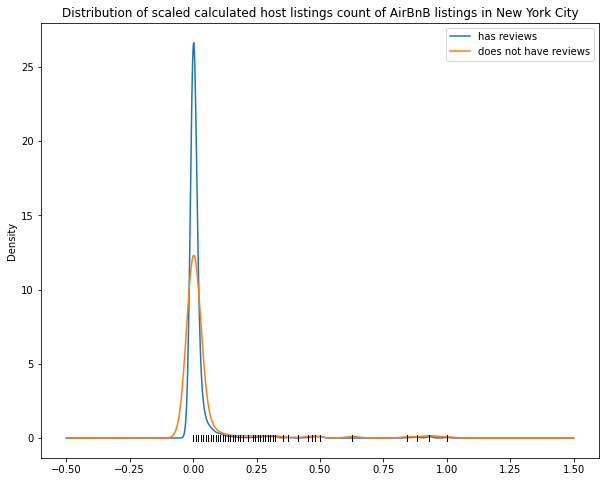

In [38]:
plot_distribution(eda_data_scaled, 'scaled_calculated_host_listings_count')

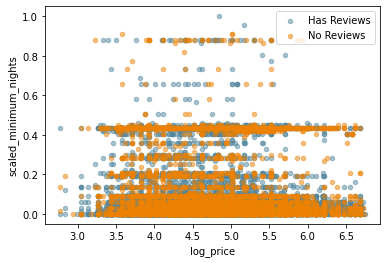

In [39]:
def plot_two_variables(df, var1, var2):
    ax = df[df['has_reviews']==1].plot(kind = 'scatter', x = var1, y = var2, 
                                  label = 'Has Reviews', color = '#50869D', 
                                  alpha = 0.5)
    df[df['has_reviews']==0].plot(kind = 'scatter',x = var1, y = var2, 
                                       label = 'No Reviews', color = '#ED8103',
                                       alpha = 0.5, ax=ax)
    ax.legend();
    
plot_two_variables(eda_data, 'log_price', 'scaled_minimum_nights')

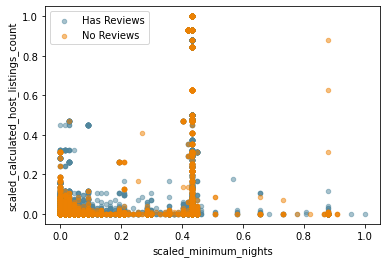

In [40]:
plot_two_variables(eda_data, 'scaled_minimum_nights', 'scaled_calculated_host_listings_count')

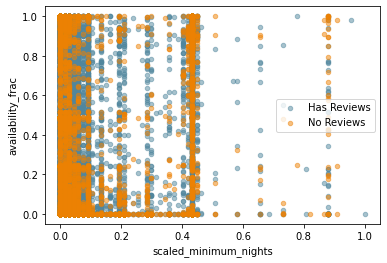

In [86]:
plot_two_variables(eda_data, 'scaled_minimum_nights', 'availability_frac')

sns.pairplot(eda_data[['has_reviews', 'log_price', 'availability_frac', 'room_type_entire_home/apt',
       'room_type_private_room', 'scaled_minimum_nights',
       'scaled_calculated_host_listings_count', 'scaled_longitude',
       'scaled_latitude']])

There are a number of measures that have not been taken that will be tested to see if they improve model accuracy after the first round of model training:
   
- downsampling listings with reviews

For now, all of the preprocessing steps above will be repeated on X_train and X_test (transformers will be fit only on X_test).
    

In [42]:
eda_data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365,has_reviews,log_price,availability_frac,room_type_entire_home/apt,room_type_private_room,scaled_minimum_nights,scaled_calculated_host_listings_count,scaled_longitude,scaled_latitude
0,Brooklyn,Bedford-Stuyvesant,40.68724,-73.95068,41.0,7.0,1.0,0.0,1.0,3.737670,0.000000,0.0,1.0,0.089552,0.000000,0.110730,-0.794891
1,Manhattan,West Village,40.73002,-74.00653,200.0,7.0,1.0,50.0,1.0,5.303305,0.136986,1.0,0.0,0.089552,0.000000,-1.415242,0.000695
2,Manhattan,Chelsea,40.74114,-74.00358,198.0,30.0,1.0,125.0,0.0,5.293305,0.342466,1.0,0.0,0.432836,0.000000,-1.334640,0.207495
3,Manhattan,Harlem,40.82329,-73.95184,110.0,3.0,3.0,64.0,0.0,4.709530,0.175342,0.0,1.0,0.029851,0.019608,0.079035,1.735251
4,Manhattan,West Village,40.73386,-74.00460,199.0,1.0,1.0,0.0,1.0,5.298317,0.000000,1.0,0.0,0.000000,0.000000,-1.362509,0.072108


In [43]:
one_hot_encoder = OneHotEncoder()
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
outlier_remover = OutlierRemover()

def apply_transformations(df, fit = True):
    new_df = df.copy()
    new_df['availability_frac'] = new_df['availability_365'] / 365
    new_df.drop(columns = ['availability_365'], inplace = True)
    numeric_features = new_df.select_dtypes('number').columns
    if fit:
        outlier_removed_df = outlier_remover.fit_transform(new_df, numeric_features)
    else:
        outlier_removed_df = outlier_remover.transform(new_df)
    log_df = transform_log_normal_variables(outlier_removed_df, ['price'], drop = True)
    ohe_df = one_hot_encode(log_df, 'room_type', one_hot_encoder, col_to_drop = 'Shared room', fit = fit)
    minmax_scaled_df = scale_data(ohe_df, ['minimum_nights', 'calculated_host_listings_count'], 
                                  minmax_scaler, drop = True, fit = fit)
    standard_scaled_df = scale_data(minmax_scaled_df, ['longitude', 'latitude', 'log_price'],
                                   standard_scaler, drop = True, fit = fit)
    return standard_scaled_df

proc_train = apply_transformations(raw_train, fit = True)
proc_test = apply_transformations(raw_test, fit = False)
proc_train.head()

,neighbourhood_group,neighbourhood,has_reviews,availability_frac,room_type_entire_home/apt,room_type_private_room,scaled_minimum_nights,scaled_calculated_host_listings_count,scaled_longitude,scaled_latitude,scaled_log_price
0,Brooklyn,Bedford-Stuyvesant,1,0.000000,0.0,1.0,0.089552,0.000000,0.110460,-0.794877,-1.502178
1,Manhattan,West Village,1,0.136986,1.0,0.0,0.089552,0.000000,-1.415415,0.000767,0.905398
2,Manhattan,Chelsea,0,0.342466,1.0,0.0,0.432836,0.000000,-1.334819,0.207582,0.890020
3,Manhattan,Harlem,0,0.175342,0.0,1.0,0.029851,0.019608,0.078768,1.735448,-0.007687
4,Manhattan,West Village,1,0.000000,1.0,0.0,0.000000,0.000000,-1.362686,0.072185,0.897729


In [44]:
proc_train.describe()

,has_reviews,availability_frac,room_type_entire_home/apt,room_type_private_room,scaled_minimum_nights,scaled_calculated_host_listings_count,scaled_longitude,scaled_latitude,scaled_log_price
count,33270.000000,33270.000000,33270.000000,33270.000000,33270.000000,33270.000000,3.327000e+04,3.327000e+04,3.327000e+04
mean,0.802645,0.295871,0.513165,0.462188,0.070490,0.026043,2.729747e-13,9.143540e-14,8.275049e-16
std,0.398008,0.355005,0.499834,0.498576,0.129281,0.109198,1.000015e+00,1.000015e+00,1.000015e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.696169e+00,-3.055711e+00,-7.249827e+00
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.596440e-01,-7.335022e-01,-7.166490e-01
50%,1.000000,0.101370,1.000000,0.000000,0.029851,0.000000,-2.587128e-02,-1.150092e-01,-7.856374e-02
75%,1.000000,0.583562,1.000000,1.000000,0.059701,0.009804,4.626275e-01,6.280939e-01,7.011511e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.856711e+00,3.021721e+00,3.120937e+00


## Feature Selection

For now, we will ignore the neighbourhoods and neighbourhood groups assuming that the longitude and latitude information is enough for listings in the same neighbourhood to be considered similar.

This leaves us with the following columns:

In [46]:
cols_to_drop = ['neighbourhood_group', 'neighbourhood']

proc_train.drop(columns = cols_to_drop, inplace = True)
proc_test.drop(columns = cols_to_drop, inplace = True)
proc_train.columns

Index(['has_reviews', 'availability_frac', 'room_type_entire_home/apt',
       'room_type_private_room', 'scaled_minimum_nights',
       'scaled_calculated_host_listings_count', 'scaled_longitude',
       'scaled_latitude', 'scaled_log_price'],
      dtype='object')

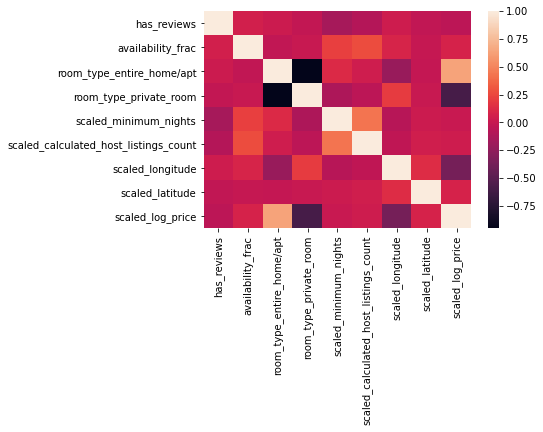

In [47]:
corrMatrix = proc_train.corr()
sns.heatmap(corrMatrix);

In [48]:
y_train = proc_train.pop('has_reviews')
X_train = proc_train.copy()

y_test = proc_test.pop('has_reviews')
X_test = proc_test.copy()

In [49]:
# Convert X_train, X_test, y_train, and y_test to numpy

X_train_np, X_test_np, y_train_np, y_test_np =  [df.to_numpy() for df in [X_train, X_test, y_train, y_test]]

y_train_np.shape

(33270,)

## Statistical Analysis

### Evaluation metric

How choose appropriate evaluation metric.

F1 score - balances precision and recall. Use 'macro' average so that if score is poor for the minor class it still impacts the score. Also find F1 score of each label.

We are more interested in the negative class - it's more important to accurately predict the negative class than the positive. It's better to encourage a vendor who is likely to succeed than to fail to nudge a vendor who is unlikely to succeed.

## Logistic Regression


F1 scores for  Logistic Regression :

F1 score of positive class: 	 0.7195121951219513 
F1 score of negative class: 	 0.37572702597906166 
Macro average F1 score: 	 0.5476196105505065


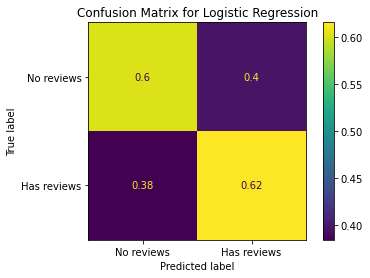

In [50]:
lr = LogisticRegression(C = 1, class_weight = 'balanced')

lr.fit(X_train_np, y_train_np)

target_names = ["No reviews", "Has reviews"]

def evaluate_model(model, X_test, y_test, model_name: str):
    y_pred = model.predict(X_test)
    print("F1 scores for ", model_name, ":\n")
    print("F1 score of positive class: \t", f1_score(y_test, y_pred, pos_label = 1),
         "\nF1 score of negative class: \t", f1_score(y_test, y_pred, pos_label = 0),
         "\nMacro average F1 score: \t", f1_score(y_test, y_pred, average = 'macro'))
    ax = plot_confusion_matrix(model, 
                      X_test, 
                      y_test, 
                      normalize = 'true', 
                      display_labels = target_names)
    plt.title("Confusion Matrix for " + model_name);
    return y_pred

y_pred = evaluate_model(lr, X_test_np, y_test_np, "Logistic Regression");

In [51]:
classif_report = classification_report(y_test_np, y_pred, target_names=target_names)
print(classif_report)

              precision    recall  f1-score   support

  No reviews       0.27      0.60      0.38      1606
 Has reviews       0.87      0.62      0.72      6713

    accuracy                           0.61      8319
   macro avg       0.57      0.61      0.55      8319
weighted avg       0.75      0.61      0.65      8319



## Support Vector Machine



F1 scores for  Support Vector Machine :

F1 score of positive class: 	 0.893486385477843 
F1 score of negative class: 	 0.03506650544135429 
Macro average F1 score: 	 0.4642764454595986


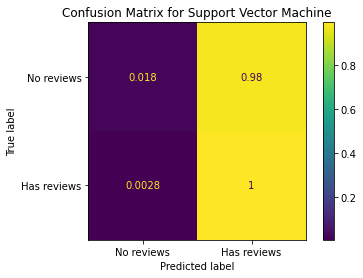

In [52]:
svm = SVC(kernel = 'rbf')
svm.fit(X_train_np, y_train_np)

evaluate_model(svm, X_test_np, y_test_np, "Support Vector Machine");

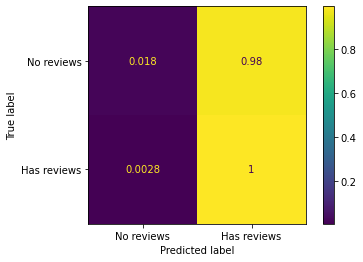

In [53]:
plot_confusion_matrix(svm, X_test_np, y_test_np, normalize = 'true', display_labels = target_names);

The SVM has labelled almost every observation as 'has reviews'. This is likely due to the imbalance in classes, which will be addressed in the second attempt.

## Decision Tree

F1 scores for  Decision Tree :

F1 score of positive class: 	 0.8228606078981278 
F1 score of negative class: 	 0.32162554426705364 
Macro average F1 score: 	 0.5722430760825907


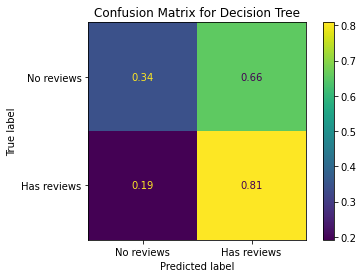

In [54]:
tree = DecisionTreeClassifier()

tree.fit(X_train_np, y_train_np)

evaluate_model(DecisionTreeClassifier().fit(X_train_np, y_train_np), X_test_np, y_test_np, "Decision Tree");

It seems that the imbalance in class labels is causing the models to perform poorly. `sklearn`'s `resample` to downsample the listings that have reviews, to see if it improves model performance. 

### Downsampling

In [55]:
# we will downsample only the training data.

def downsample(df: pd.DataFrame, target_col: str, majority_label: int) -> pd.DataFrame:
    minority_label = 1 if majority_label == 0 else 0
    # separate majority and minority class
    majority_class = df[df[target_col]== majority_label]
    minority_class = df[df[target_col]== minority_label]
    # count number of observations in minority class
    count_minority_class = len(minority_class.index)
    majority_class_downsampled = resample(majority_class, replace = False, n_samples = count_minority_class, random_state = 42)
    df_balanced = pd.concat([majority_class_downsampled, minority_class], axis = 0, sort = True)
    df_balanced.reset_index(drop=True)
    return df_balanced
    
proc_train['has_reviews'] = y_train

train_balanced = downsample(proc_train, 'has_reviews', 1)

print(train_balanced["has_reviews"].value_counts())

y_train_balanced = train_balanced.pop('has_reviews')
X_train_balanced = train_balanced

X_train_balanced.head(1)

0    6566
1    6566
Name: has_reviews, dtype: int64


,availability_frac,room_type_entire_home/apt,room_type_private_room,scaled_calculated_host_listings_count,scaled_latitude,scaled_log_price,scaled_longitude,scaled_minimum_nights
1069,0.243836,1.0,0.0,0.009804,0.709183,0.465559,0.076036,0.029851


F1 scores for  Logistic Regression :

F1 score of positive class: 	 0.6750044037343668 
F1 score of negative class: 	 0.30166540499621497 
Macro average F1 score: 	 0.48833490436529087


,feature,coef
7,scaled_minimum_nights,-3.224109
1,room_type_entire_home/apt,1.424085
0,availability_frac,1.046963
3,scaled_calculated_host_listings_count,-0.977552
2,room_type_private_room,0.637336
5,scaled_log_price,-0.415289
6,scaled_longitude,-0.023423
4,scaled_latitude,-0.013746


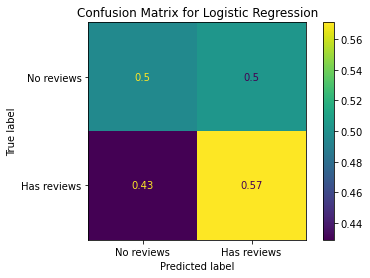

In [56]:
lr = LogisticRegression()

lr.fit(X_train_balanced, y_train_balanced)

evaluate_model(lr, X_test, y_test, "Logistic Regression")

coefficients = pd.DataFrame(data = {
    'feature': X_train_balanced.columns,
    'coef': lr.coef_[0],
    'coef_magnitude': [abs(c) for c in lr.coef_[0]]
})
coefficients.sort_values('coef_magnitude', ascending = False).drop(columns = ['coef_magnitude'])

The logistic regression model actually appears to perform worse when the training data is downsampled; this may be because of the significant reduction in the size of the training dataset.

In [57]:
print("Size of original dataset: ", len(X_train),
      "\nSize of downsampled dataset: ", len(X_train_balanced),
     "\nSize of test dataset: ", len(X_test))

Size of original dataset:  33270 
Size of downsampled dataset:  13132 
Size of test dataset:  8319


We can increase the size of the training dataset by splitting the original dataset again taking a smaller slice for testing.

In [123]:
raw_train_, raw_test_ = train_test_split(airbnb, test_size = 0.08, random_state = 42)

# Apply preprocessing steps as above
raw_train_ = encode_target(raw_train_)
downsample_demo = raw_train_.copy().reset_index()

raw_test_ = encode_target(raw_test_)
raw_train_ = apply_transformations(raw_train_, fit = True)
raw_test_ = apply_transformations(raw_test_, fit = False)

# Separate target variable in test dataset
y_test_ds = raw_test_.pop('has_reviews')
X_test_ds = raw_test_

# Downsample training dataset
raw_train_ds = downsample(raw_train_, 'has_reviews', 1)

y_train_ds = raw_train_ds.pop('has_reviews')
X_train_ds = raw_train_ds

for df in [X_train_ds, X_test_ds]:
    df.drop(columns = ['neighbourhood', 'neighbourhood_group'], inplace=True)

print("Size of original dataset: ", len(X_train),
      "\nSize of downsampled dataset: ", len(X_train_ds),
     "\n\nSize of test dataset: ", len(X_test_ds),
     "\nProportion used for test dataset: ", round(len(X_test_ds)/len(X_train_ds),2),
     "\n\nNumber of listings with reviews in training dataset: ", len(y_train_ds[y_train_ds==1]),
     "\nNumber of listings without reviews in training dataset: ", len(y_train_ds[y_train_ds==0]))

Size of original dataset:  33270 
Size of downsampled dataset:  15124 

Size of test dataset:  3320 
Proportion used for test dataset:  0.22 

Number of listings with reviews in training dataset:  7562 
Number of listings without reviews in training dataset:  7562


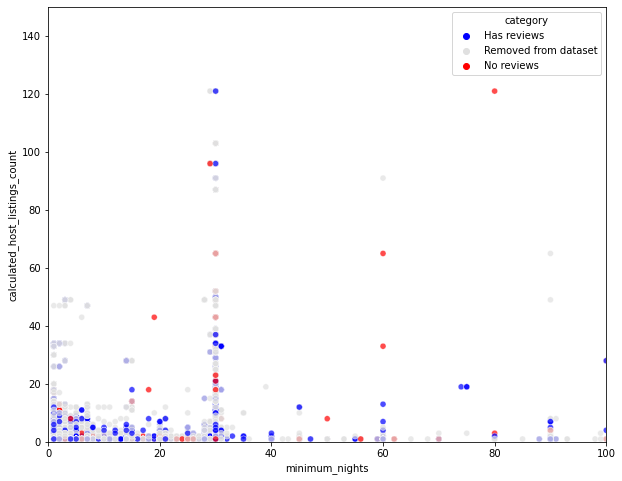

In [127]:
## visualise the downsampling

downsample_demo['in_downsampled_dataset'] = downsample_demo['index'].apply(lambda i: i in raw_train_ds.index)
categories = [
    (downsample_demo['has_reviews']==1) & (downsample_demo['in_downsampled_dataset']),
    (downsample_demo['has_reviews']==0) & (downsample_demo['in_downsampled_dataset']),
    (~downsample_demo['in_downsampled_dataset'])
]
category_labels = [
    'Has reviews', 'No reviews', 'Removed from dataset'
]

downsample_demo['category'] = np.select(categories, category_labels)

palette = {
    'Has reviews': 'blue',
    'No reviews': 'red',
    'Removed from dataset': '#E0E0E0'
}

fig, ax = plt.subplots(figsize = (10,8))
sns.scatterplot(data = downsample_demo,
                x = 'minimum_nights',
                y = 'calculated_host_listings_count',
                hue = 'category',
                alpha = 0.7,
                palette = palette,
                ax = ax)
plt.xlim(0,100)
plt.ylim(0,150);

In [59]:
X_train_ds = X_train_ds[X_test_ds.columns]
X_train_ds.head(1)

,availability_frac,room_type_entire_home/apt,room_type_private_room,scaled_minimum_nights,scaled_calculated_host_listings_count,scaled_longitude,scaled_latitude,scaled_log_price
19269,0.693151,0.0,1.0,0.043478,0.0,-1.037406,-1.090428,-0.587679


F1 scores for  Logistic Regression :

F1 score of positive class: 	 0.7361910855193005 
F1 score of negative class: 	 0.3659661711942594 
Macro average F1 score: 	 0.5510786283567799


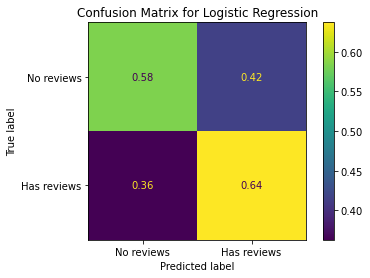

In [60]:
lr = LogisticRegression()

lr.fit(X_train_ds, y_train_ds)
y_pred_lr = lr.predict(X_test_ds)

evaluate_model(lr, X_test_ds, y_test_ds, "Logistic Regression");

,num_features,neg_class_f1
0,1,0.282927
1,2,0.249332
2,3,0.321258
3,4,0.351182
4,5,0.348792
5,6,0.362173
6,7,0.367179


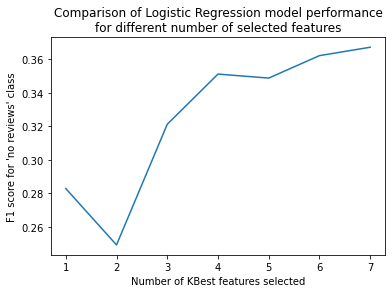

In [61]:
# Choose the best number of features

def feature_select(X_train, y_train, X_test, y_test, model, model_name):
    num_features = range(1,len(X_train.columns))
    f1_scores = []

    for num in num_features:
        kbest = SelectKBest(score_func = f_classif, k = num)
        kbest.fit(X=X_train, y = y_train)

        selected_columns = X_train.columns[kbest.get_support()]

        model.fit(X_train[selected_columns], y_train)
        y_pred = model.predict(X_test[selected_columns])

        # look specifically at the F1 score of the 'no reviews' class
        f1 = f1_score(y_test, y_pred, pos_label = 0)
        #print("Number of features: ", num, "\t\tNegative class F1 score: ", f1)
        f1_scores.append(f1)
    ax = plt.plot(num_features, f1_scores)
    plt.ylabel("F1 score for 'no reviews' class")
    plt.xlabel("Number of KBest features selected")
    plt.title(f"Comparison of {model_name} model performance\nfor different number of selected features")
    return pd.DataFrame(data = {'num_features': num_features, 'neg_class_f1': f1_scores})
    
feature_select(X_train_ds, y_train_ds, X_test_ds, y_test_ds, LogisticRegression(), "Logistic Regression")

The model actually appears to perform the best with all of the features.

In [62]:
lr.fit(X_train_ds, y_train_ds)

coefficients = pd.DataFrame(data = {
        'feature': X_test_ds.columns,
        'coef': lr.coef_[0],
        'coef_magnitude': [abs(c) for c in lr.coef_[0]]
    })

coefficients.sort_values('coef_magnitude', ascending = False).drop(columns = ['coef_magnitude'])

,feature,coef
3,scaled_minimum_nights,-3.130826
1,room_type_entire_home/apt,1.537665
0,availability_frac,1.050113
4,scaled_calculated_host_listings_count,-1.033697
2,room_type_private_room,0.734330
7,scaled_log_price,-0.418050
6,scaled_latitude,-0.005296
5,scaled_longitude,-0.004896


Let's test our new downsampled dataset with SVM.

F1 scores for  Support Vector Machine :

F1 score of positive class: 	 0.7000887311446318 
F1 score of negative class: 	 0.3658536585365853 
Macro average F1 score: 	 0.5329711948406085


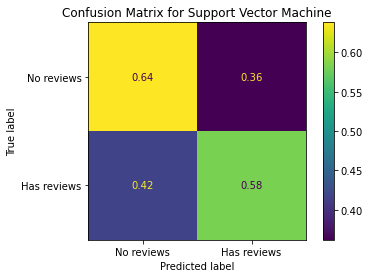

In [63]:
svm = SVC()
svm.fit(X_train_ds, y_train_ds)

evaluate_model(svm, X_test_ds, y_test_ds, "Support Vector Machine");

A marked improvement so far!

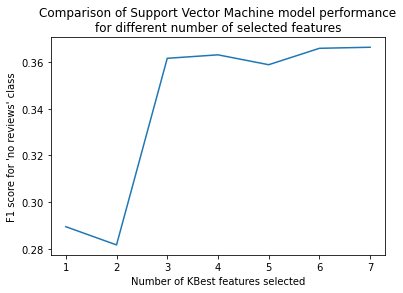

In [64]:
# try feature selection
feature_select(X_train_ds, y_train_ds, X_test_ds, y_test_ds, SVC(), "Support Vector Machine");

SVM also appears to perform best on the negative class with all of the features included.

#### Decision Tree

F1 scores for  Decision Tree :

F1 score of positive class: 	 0.7046700285025214 
F1 score of negative class: 	 0.3520923520923521 
Macro average F1 score: 	 0.5283811902974367


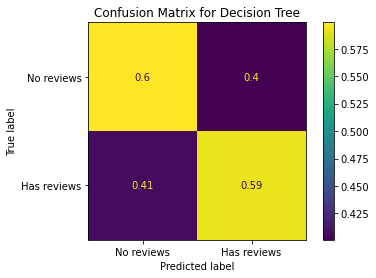

In [66]:
tree = DecisionTreeClassifier()

tree.fit(X_train_ds, y_train_ds)

evaluate_model(tree, X_test_ds, y_test_ds, "Decision Tree");

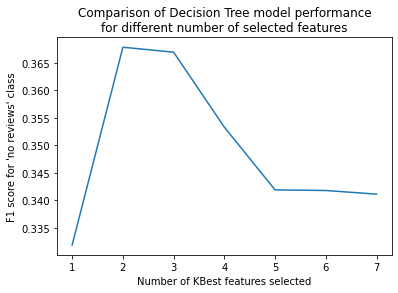

In [67]:
feature_select(X_train_ds, y_train_ds, X_test_ds, y_test_ds, tree, "Decision Tree");

F1 scores for  Decision Tree :

F1 score of positive class: 	 0.6547231270358307 
F1 score of negative class: 	 0.36635354397950465 
Macro average F1 score: 	 0.5105383355076677


'Selected features: availability_frac, scaled_calculated_host_listings_count, scaled_minimum_nights'

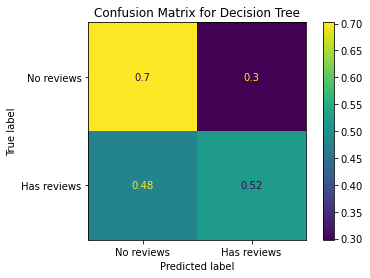

In [131]:
def get_selected_columns(X_train, y_train, k):
    kbest = SelectKBest(score_func = f_classif, k = k)
    kbest.fit(X=X_train, y = y_train)
    cols = kbest.get_support()
    selected_cols = X_train.columns[cols]
    return selected_cols

selected_features = get_selected_columns(X_train_ds, y_train_ds, 3)

tree.fit(X_train_ds[selected_features], y_train_ds)

evaluate_model(tree, X_test_ds[selected_features], y_test_ds, "Decision Tree");

'Selected features: ' + ', '.join(selected_features)

#### XGBoost

F1 scores for  XGBoost :

F1 score of positive class: 	 0.7576080017024899 
F1 score of negative class: 	 0.41318907779495107 
Macro average F1 score: 	 0.5853985397487205


array([1, 1, 0, ..., 0, 1, 1])

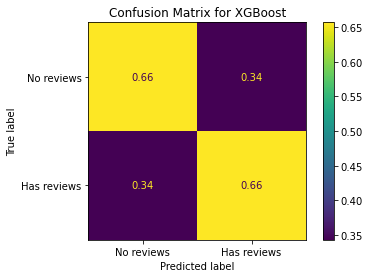

In [71]:
xgb_model = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss')

xgb_model.fit(X_train_ds, y_train_ds)

evaluate_model(xgb_model, X_test_ds, y_test_ds, "XGBoost")

# define evaluation procedure
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate model
#scores = cross_val_score(xgb_model, X_train_np, y_train_np, scoring='f1_score', cv=cv, n_jobs=-1)

,num_features,neg_class_f1
0,1,0.331882
1,2,0.369135
2,3,0.415690
3,4,0.408682
4,5,0.407676
5,6,0.413793
6,7,0.410714


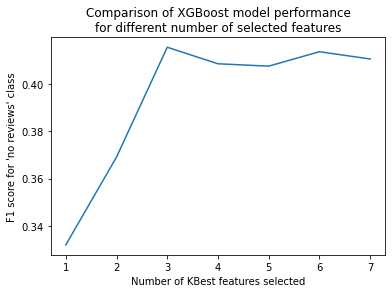

In [73]:
feature_select(X_train_ds, y_train_ds, X_test_ds, y_test_ds, xgb_model, "XGBoost")

Selected features are availability_frac, scaled_minimum_nights, scaled_calculated_host_listings_count

F1 scores for  XGBoost :

F1 score of positive class: 	 0.7547573230703444 
F1 score of negative class: 	 0.41569026999490577 
Macro average F1 score: 	 0.585223796532625


array([0, 1, 0, ..., 0, 1, 1])

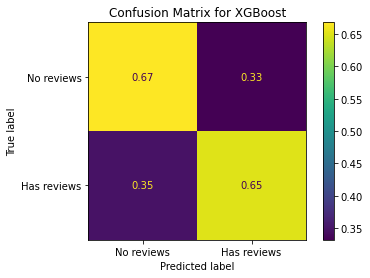

In [79]:
selected_features = get_selected_columns(X_train_ds, y_train_ds, 3)
print(
    f"Selected features are {', '.join(selected_features.tolist())}\n"
)

xgb_model.fit(X_train_ds[selected_features], y_train_ds)

evaluate_model(xgb_model, X_test_ds[selected_features], y_test_ds, "XGBoost")

In [75]:
selected_features

Index(['availability_frac', 'scaled_minimum_nights',
       'scaled_calculated_host_listings_count'],
      dtype='object')




With XGBoost the model seems to perform best at predicting the 0 class when all of the features are used. It stands to reason that it could perform even better if given an additional feature (neighbourhood group and/or neighbourhood), but first we will compare with XGBoost on non-downsampled data, using its `scale_pos_weight` parameter.

### Using XGBoost's `scale_pos_weight`

Using the scale_pos_weight parameter to adjust for imbalanced classes (see [this](https://machinelearningmastery.com/xgboost-for-imbalanced-classification/#:~:text=The%20XGBoost%20algorithm%20is%20effective,over%20the%20model%20training%20procedure.) blog post).


In [ ]:
prop_no_reviews = sum(y_train==0)/sum(y_train==1)
prop_no_reviews

In [ ]:
xgb_model = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', scale_pos_weight = prop_no_reviews)

xgb_model.fit(X_train, y_train)

evaluate_model(xgb_model, X_test, y_test, "XGBoost");

In [ ]:
feature_select(X_train, y_train, X_test, y_test, xgb_model, "XGBoost");

The model appears to work best with a higher number of features; however, the four features will be tested for comparison as this may lead to a less complex (and therefore more explainable) model.

In [ ]:
selected_features = get_selected_columns(X_train, y_train, 4)

xgb_model.fit(X_train[selected_features], y_train)

evaluate_model(xgb_model, X_test[selected_features], y_test, "XGBoost");

### Model Selection

At this stage all of the models evaluated will be compared. Two will be selected for tuning. These two selected models will be used to:
1. Examine feature importance to understand what contributes to a listing having (or not having) reviews
2. Develop a predictive model that can be used by AirBnB to identify and 'nudge' owners of listings that are unlikely to be reviewed.

The two best models for f1 score of the 0 class are:

1. XGBoost (using scale_pos_weight, all features)
2. SVM (on downsampled data, 5 best features)

Since XGBoost on downsampled data performed the third best for this metric it will be selected instead, so that the models can be fairly compared on the same test set.

The two best models for accuracy of the 0 class are:

1. XGBoost (on downsampled data, all features)
2. SVM (on downsampled data, 5 best features)

This validates their selection as the two best models for the purpose.

Before tuning these models farther, we should examine the 5 "best" features as selected for SVM by sklearn's `SelectKBest`.

In [ ]:
get_selected_columns(X_train_ds, y_train_ds, 5)

### Feature Importance



In [ ]:
plot_importance(xgb_model, importance_type = 'gain');

In [ ]:
feature_importances = {feature: importance for feature, importance in zip(X_test.columns, xgb_model.feature_importances_)}

for f, i in feature_importances.items():
    print(f"{f}: \t{i}")


### Exploring Results


In [ ]:
results_scaled = X_test.copy()
results_scaled['y'] = y_test
results_scaled['y_pred'] = y_pred
results_scaled.head()

In [ ]:
ax = plot_distribution(results_scaled, 'scaled_minimum_nights', color_split = 'y_pred', title = 'All predictions')
ax.set_xlim(left = 0, right = 1);

In [ ]:
print(len(X_test))

print(len(raw_test))

In [ ]:
# group the availability fractions into bins
results_scaled['availability_cat'] = results_scaled['availability_frac'].apply(lambda x: math.floor((x*100)/10)/10)

# calculate the f1_score for each bin
f1_scores = {}
prop = {}
for cat in [round(x,1) for x in np.linspace(0.0, 0.9, 10)]:
    sample = results_scaled[results_scaled['availability_cat']==cat]
    f1_scores[cat] = f1_score(sample['y'], sample['y_pred'], average = 'macro')
    prop[cat] = len(sample[sample['y']==0])
for cat, f1 in f1_scores.items():
    print(f"{cat}: {f1}")

print()
for cat, p in prop.items():
    print(cat, ': ', p)

In [ ]:
# inspect the original (unscaled/unencoded) dataframe also
results = raw_test.copy()
results['availability_frac'] = results['availability_365']/365
results.drop(columns = ['availability_365'], inplace = True)
results = outlier_remover.transform(results)
results['prediction'] = y_pred

room_type_results = {}
room_type_count = {}

for room_type in results['room_type'].unique():
    temp = results[results['room_type']==room_type]
    room_type_count[room_type] = len(temp)
    room_type_results[room_type] = f1_score(temp['has_reviews'], temp['prediction'], average = 'macro')
    
for room_type, score in room_type_results.items():
    print(f'{room_type}/n Count: {room_type_count[room_type]}\tMacro F1 score: {score: .3f}')

In [ ]:
plt.scatter(x = results[''])

In [ ]:
len(re)